In [62]:
import os
import torch
from torchvision.models import resnet50, ResNet50_Weights
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import warnings
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torchvision import models
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
print(torch.__version__)
print(torch.version.cuda)

2.5.1+cu121
12.1


In [63]:
model = resnet50(weights=ResNet50_Weights.DEFAULT)
num_classes = 3  #3 classes (american, russian, israeli)
model.fc = nn.Linear(model.fc.in_features, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device)

optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

Using device: cuda


In [64]:
image_dir = "data_combined/train"
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

In [65]:
def load_images_and_labels(image_dir, transform):
    images, labels = [], []
    for fname in os.listdir(image_dir):
        if not fname.endswith(".jpg"):
            continue
        try:
            image = transform(Image.open(os.path.join(image_dir, fname)).convert("RGB"))
            images.append(image)
            label_str = fname.split("_")[0]
            if label_str == "american":
                label = 0
            elif label_str == "russian":
                label = 1
            else:
                label = 2
            labels.append(label)
        except Exception as e:
            print(f"Skipping {fname}: {e}")
    images = torch.stack(images)
    labels = torch.tensor(labels)
    return images, labels
images, labels = load_images_and_labels(image_dir, transform)
images = images.to(device)  
labels = labels.to(device)  


In [66]:

dataset = TensorDataset(images, labels)
batch_size = 16 

loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
torch.cuda.empty_cache()
from tqdm import tqdm

model.train()
for epoch in range(5):
    batch_iter = tqdm(loader, desc=f"Epoch {epoch+1}", leave=False)
    for batch_images, batch_labels in batch_iter:
        optimizer.zero_grad()
        outputs = model(batch_images)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        batch_iter.set_postfix(loss=loss.item())
    print(f"Epoch {epoch+1}\n")

Epoch 1



Epoch 2



Epoch 3



Epoch 4



Epoch 5



Validation set performance:
Accuracy: 0.9556
Classification Report:
               precision    recall  f1-score   support

    american       0.98      0.89      0.93        53
     russian       0.87      0.99      0.93       123
     israeli       0.99      0.95      0.97       320

    accuracy                           0.96       496
   macro avg       0.95      0.94      0.94       496
weighted avg       0.96      0.96      0.96       496



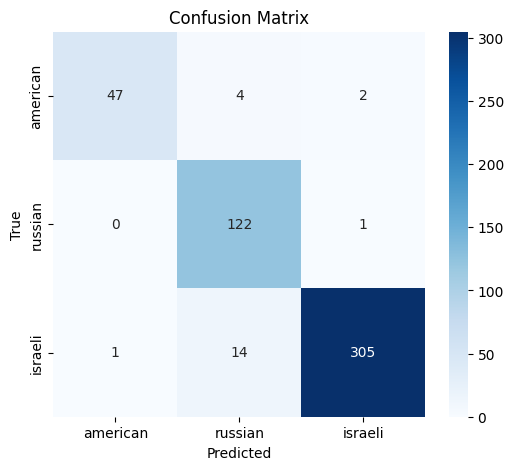

Test set performance:
Accuracy: 0.9310
Classification Report:
               precision    recall  f1-score   support

    american       0.97      0.67      0.79        48
     russian       0.84      1.00      0.91       114
     israeli       0.99      0.95      0.97       215

    accuracy                           0.93       377
   macro avg       0.93      0.87      0.89       377
weighted avg       0.94      0.93      0.93       377



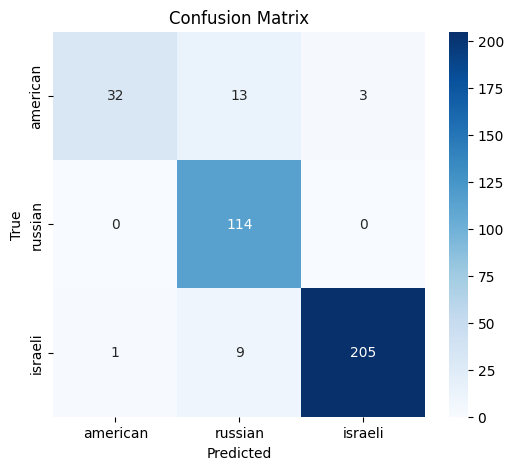

In [67]:

def evaluate(model, images, labels, device, class_names=["american", "russian", "israeli"]):
    model.eval()
    with torch.no_grad():
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        accuracy = (preds == labels).float().mean().item()
    print(f"Accuracy: {accuracy:.4f}")
    cm = confusion_matrix(labels.cpu(), preds.cpu())
    print("Classification Report:\n", classification_report(labels.cpu().numpy(), preds.cpu().numpy(), target_names=class_names))
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

val_images, val_labels = load_images_and_labels("data_combined/valid", transform)
test_images, test_labels = load_images_and_labels("data_combined/test", transform)

val_images, val_labels = val_images.to(device), val_labels.to(device)
test_images, test_labels = test_images.to(device), test_labels.to(device)

print("Validation set performance:")
evaluate(model, val_images, val_labels, device)

print("Test set performance:")
evaluate(model, test_images, test_labels, device)

In [68]:

image_path = "merkava_1.jpg" 

model.eval()

transform = transforms.Compose([
    transforms.Resize((256, 256)), 
    transforms.ToTensor(),
])


image = Image.open(image_path).convert("RGB")
image_tensor = transform(image).unsqueeze(0).to(device) 

with torch.no_grad():
    outputs = model(image_tensor)
    pred = outputs.argmax(dim=1).item()

classes = ["american", "russian", "israeli"]
print(f"Predicted class: {classes[pred]}")

Predicted class: israeli


Random Forest Test Accuracy: 86.74%

Classification Report:
               precision    recall  f1-score   support

    american       0.78      0.38      0.51        48
     russian       0.78      0.99      0.88       114
     israeli       0.93      0.91      0.92       215

    accuracy                           0.87       377
   macro avg       0.83      0.76      0.77       377
weighted avg       0.87      0.87      0.86       377



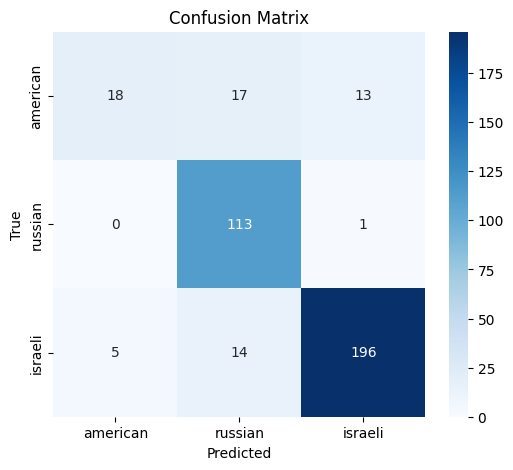

In [69]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

resnet = models.resnet50(pretrained=True)
resnet = nn.Sequential(*list(resnet.children())[:-1]) 
resnet.to(device)
resnet.eval()

def extract_features(image_tensors):
    feats = []
    with torch.no_grad():
        for img in image_tensors:
            if img.ndim == 3:
                img = img.unsqueeze(0)
            img = img.to(device)
            f = resnet(img).cpu().numpy().flatten()
            feats.append(f)
    return np.array(feats)

X_train = extract_features(images)
X_val   = extract_features(val_images)
X_test  = extract_features(test_images)

y_train = labels.cpu().numpy() if torch.is_tensor(labels) else np.array(labels)
y_val   = val_labels.cpu().numpy() if torch.is_tensor(val_labels) else np.array(val_labels)
y_test  = test_labels.cpu().numpy() if torch.is_tensor(test_labels) else np.array(test_labels)

rf = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42, criterion='entropy')
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"Random Forest Test Accuracy: {acc*100:.2f}%\n")

cm = confusion_matrix(y_test, y_pred)
class_names = ["american", "russian", "israeli"]

print("Classification Report:\n", classification_report(y_test, y_pred, target_names=class_names))
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
